Find a single-humped dataset on the Web. The most original datasets will get the highest bonuses.
Figure out the best possible match using the mathematical functions we learned about. Use Math and MLE to find the best parameters.
Now, repeat the experiment with programming and PyMC3.
Which method was the most fun?

In [136]:
import pandas as pd #Dataset is PM2.5 record of Singapore since 2016.
import math as m
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
df = pd.read_csv("data/pm.csv")
df.head()

,national,south,north,east,central,west,timestamp
0,47,44,37,47,47,34,2016-02-07T18:00:00+08:00
1,59,57,54,59,57,56,2016-02-08T23:00:00+08:00
2,59,57,55,59,57,56,2016-02-09T01:00:00+08:00
3,59,57,55,59,56,56,2016-02-09T02:00:00+08:00
4,59,58,55,59,56,56,2016-02-09T03:00:00+08:00


# EDA

In [137]:
df=df[['national']]/3
df.head()

,national
0,15.666667
1,19.666667
2,19.666667
3,19.666667
4,19.666667


16.83407723225166
<class 'float'>


/home/fei/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


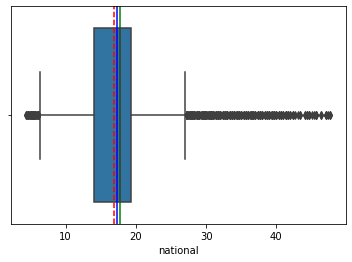

In [138]:
import seaborn as sns
f, (ax_box) = plt.subplots(1, sharex=True)
mean=df['national'].mean()
median=df['national'].median()
mode=df['national'].mode()[0]
print(mean)
print(type(median))
sns.boxplot(df["national"], ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')

In [139]:
def no_outliers(x):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    valid_values = ~((x < (Q1 - 1.5 * IQR)) |(x > (Q3 + 1.5 * IQR)))
    return valid_values

In [140]:
df.loc[no_outliers(df.national)==False,'national']=np.nan
df.loc[no_outliers(df.national)==False,'national']=np.nan
df.fillna(int(median),inplace=True)

In [141]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
national,30022.0,16.666322,3.836438,6.333333,14.0,17.666667,19.333333,27.0


<AxesSubplot:xlabel='national'>

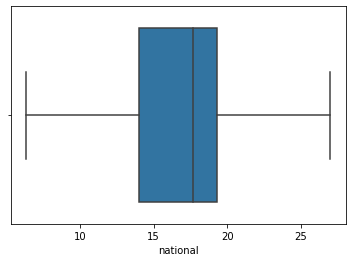

In [142]:
sns.boxplot(x=df['national'])

# MOM and MLE

In [143]:
precip_mean = df.mean()
precip_mean

precip_var = df.var()
precip_var

alpha_mom = precip_mean ** 2 / precip_var
beta_mom = precip_var / precip_mean
alpha_mom, beta_mom

(national    18.872229
 dtype: float64,
 national    0.883114
 dtype: float64)

In [144]:
from scipy.special import psi, polygamma

# Note that log_mean and mean_log are parameters of the dlgamma function
dlgamma = lambda m, log_mean, mean_log: np.log(m) - psi(m) - log_mean + mean_log
dl2gamma = lambda m, *args: 1./m - polygamma(1, m)

In [145]:
# Calculate statistics
log_mean = df.mean().apply(np.log)
mean_log = df.apply(np.log).mean()

In [146]:
# Alpha MLE for December
from scipy.special import psi, polygamma
from scipy.optimize import newton
alpha_mle = newton(dlgamma, 2, dl2gamma, args=(log_mean[-1], mean_log[-1]))
alpha_mle

16.270941901341047

In [147]:
beta_mle = alpha_mle/df.mean()[-1]
beta_mle

0.9762766756799344

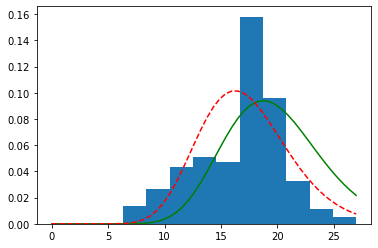

In [152]:
from scipy.stats.distributions import gamma

dec = df.national
dec.hist(density=True, bins=10, grid=False)
x = np.linspace(0, dec.max())
plt.plot(x, gamma.pdf(x, alpha_mom[-1], beta_mom[-1]), 'g-')
plt.plot(x, gamma.pdf(x, alpha_mle, beta_mle), 'r--')

In [126]:
from scipy.stats import gamma
from pymc3 import Deterministic

gamma.fit(df.national)

(264.3718850284753, -46.70281096565181, 0.239555412752957)

In [127]:
from pymc3 import Model, Uniform

with Model() as air_model:
    μ_0 = Normal('μ_0', 100, sd=10)
    μ_1 = Normal('μ_1', 100, sd=10)

In [128]:
with air_model:
    σ_0 = Uniform('σ_0', lower=0, upper=20)
    σ_1 = Uniform('σ_1', lower=0, upper=20)

/home/fei/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


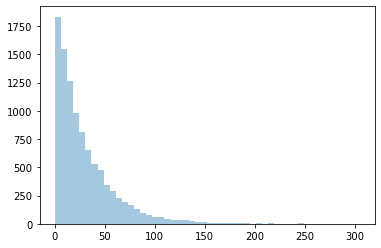

In [129]:
from pymc3 import Exponential
sns.distplot(Exponential.dist(1/29).random(size=10000), kde=False);

In [130]:
with air_model:
    ν = Exponential('ν_minus_one', 1/29.) + 1

In [131]:
from pymc3 import Deterministic
    
with air_model:
    diff_of_means = Deterministic('difference of means', μ_1 - μ_0)
    effect_size = Deterministic('effect size', diff_of_means / np.sqrt((σ_1**2 + σ_0**2) / 2))

In [132]:
from pymc3 import fit
from pymc3 import Model, Uniform, StudentT, Normal

RANDOM_SEED = 20090425
with air_model: 
    Air_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Finished [100%]: Average Loss = 1.6604


Got error No model on context stack. trying to find log_likelihood in translation.
/home/fei/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


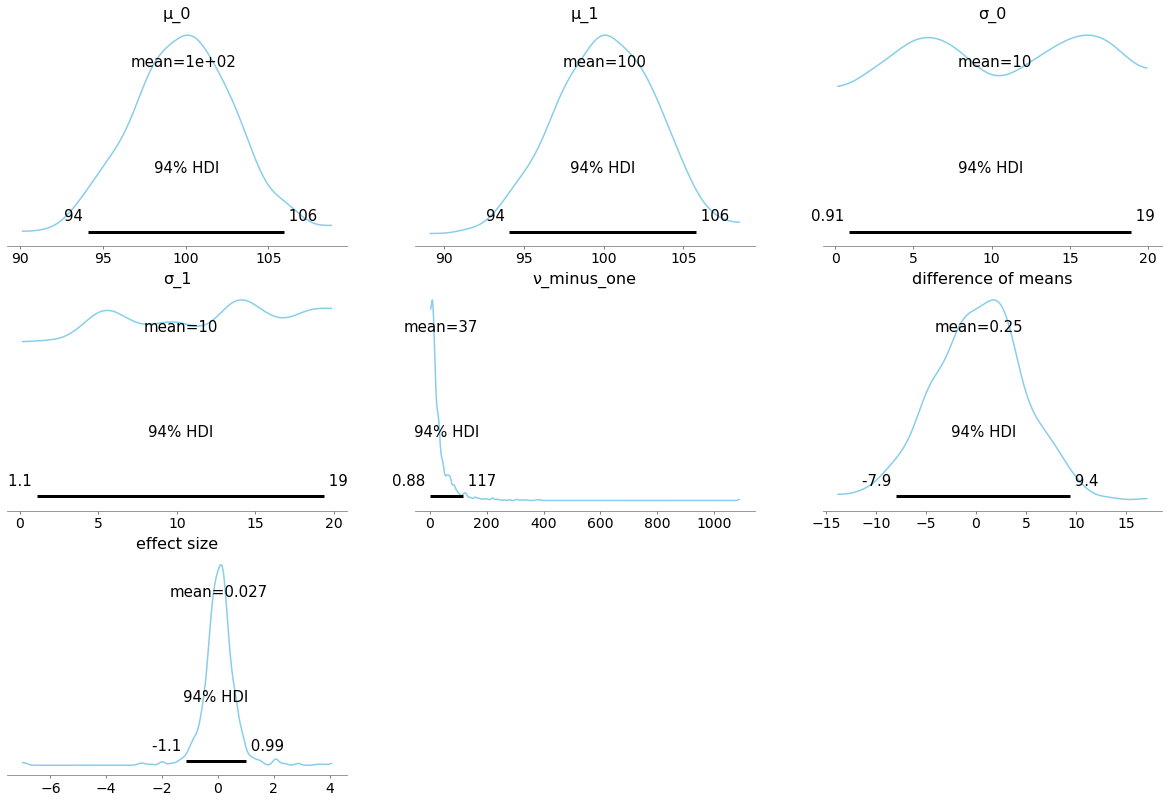

In [133]:
from pymc3 import plot_posterior

plot_posterior(Air_trace[100:], 
                color='#87ceeb');

Got error No model on context stack. trying to find log_likelihood in translation.
/home/fei/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


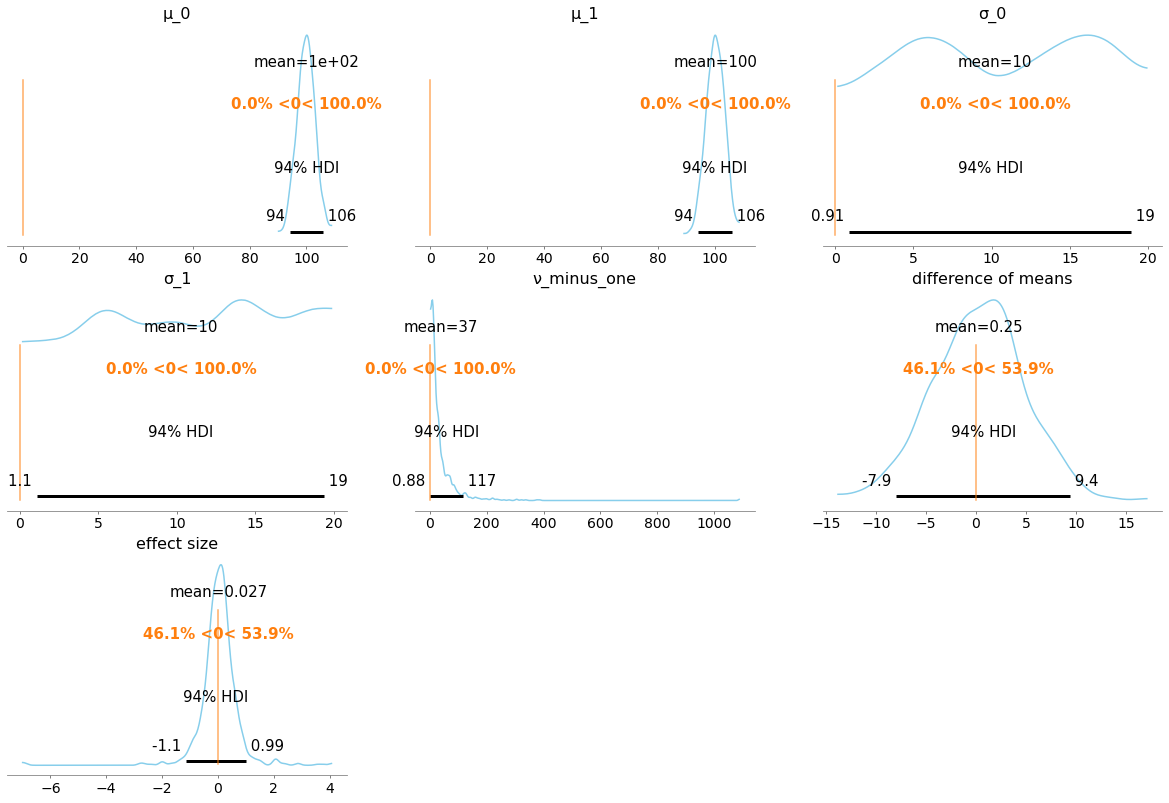

In [134]:
plot_posterior(Air_trace[100:], 
          ref_val=0,
          color='#87ceeb');

**Prediction:**

According to the histograms, the PM2.5 rate is around 55 most of the days in Singapore. The range of PM2.5 is from 10 to 80. 
And it meets the requirement of gamma distribution.